###Installing Dependencies

In [2]:
!pip install tensorflow numpy pandas scikit-learn gdown

### Importing Libraries


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import pickle

###Downloading the Dataset

In [4]:
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1-i3ydFccyOoEAlAAUeESomiMfpOCoiia" -O classification_data.csv

--2025-05-10 04:01:18--  https://docs.google.com/uc?export=download&id=1-i3ydFccyOoEAlAAUeESomiMfpOCoiia
Resolving docs.google.com (docs.google.com)... 142.251.12.100, 142.251.12.138, 142.251.12.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1-i3ydFccyOoEAlAAUeESomiMfpOCoiia&export=download [following]
--2025-05-10 04:01:18--  https://drive.usercontent.google.com/download?id=1-i3ydFccyOoEAlAAUeESomiMfpOCoiia&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42846354 (41M) [application/octet-stream]
Saving to: ‘classification_data.csv’

classification_data 100%[===================>]  40.86M   1

###Initial Data Exploration

In [5]:
combined_df = pd.read_csv('classification_data.csv')

In [6]:
combined_df.head()    # 0: Science, 1: Math, 2: History

,train,label
0,"Like the Buddhists, Jaina scholars produced a ...",2
1,"1000 BCE onwards, was to classify people (espe...",2
2,sin sin ( )x x + α.1 1x x- +.2 sin 2 1 cos 2xx...,1
3,( ) x cf x f cx cx c →- - - or lim [ ( )] l...,1
4,Write word equations and then balanced equatio...,0


###Data Handling

In [7]:
combined_df['train'] = combined_df['train'].fillna('')  # Replace NaN with empty string
combined_df['train'] = combined_df['train'].astype(str)  # Convert all values to strings

In [8]:
texts = combined_df['train'].values
labels = combined_df['label'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=41)

In [10]:
max_words = 3000
max_sequence_length = 400

##Tokenizer Initialization and Fitting

In [11]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [12]:
with open("classifier_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f) #Saves the tokenizer

In [13]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

###Model Building

In [22]:
def build_model(vocab_size, max_sequence_length):
    model = tf.keras.Sequential([
        # Embedding layer
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256,
                                 input_shape=(max_sequence_length,)),

        # Single Bidirectional LSTM
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.3)),

        # Dense layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),

        # Output layer
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=2.5e-4,
            weight_decay=0.003,
            beta_1=0.9,
            beta_2=0.999),
        metrics=['accuracy']
    )

    return model

###Overview of the layers, output shapes, and number of parameters.

In [29]:
vocab_size = min(len(tokenizer.word_index) + 1, max_words)  # +1 for padding token
model = build_model(vocab_size, max_sequence_length)

# Build the model by calling it with a sample input shape
model.build((None, max_sequence_length))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 400, 256)       │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,195,523 (4.56 MB)

 Trainable params: 1,195,523 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

###Training the Model

In [30]:
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=256,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.4615 - loss: 1.0555 - val_accuracy: 0.6333 - val_loss: 0.8767
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.6837 - loss: 0.8003 - val_accuracy: 0.7932 - val_loss: 0.5606
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7844 - loss: 0.5627 - val_accuracy: 0.8235 - val_loss: 0.4690
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.8236 - loss: 0.4479 - val_accuracy: 0.8708 - val_loss: 0.3757
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8827 - loss: 0.3295 - val_accuracy: 0.8775 - val_loss: 0.3291
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9031 - loss: 0.2657 - val_accuracy: 0.8900 - val_loss: 0.2991
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9151 - loss: 0.2340 - val_accuracy: 0.8908 - val_loss: 0.2975
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9266 - loss: 0.2108 - val_accurac

###Plot the training graphs

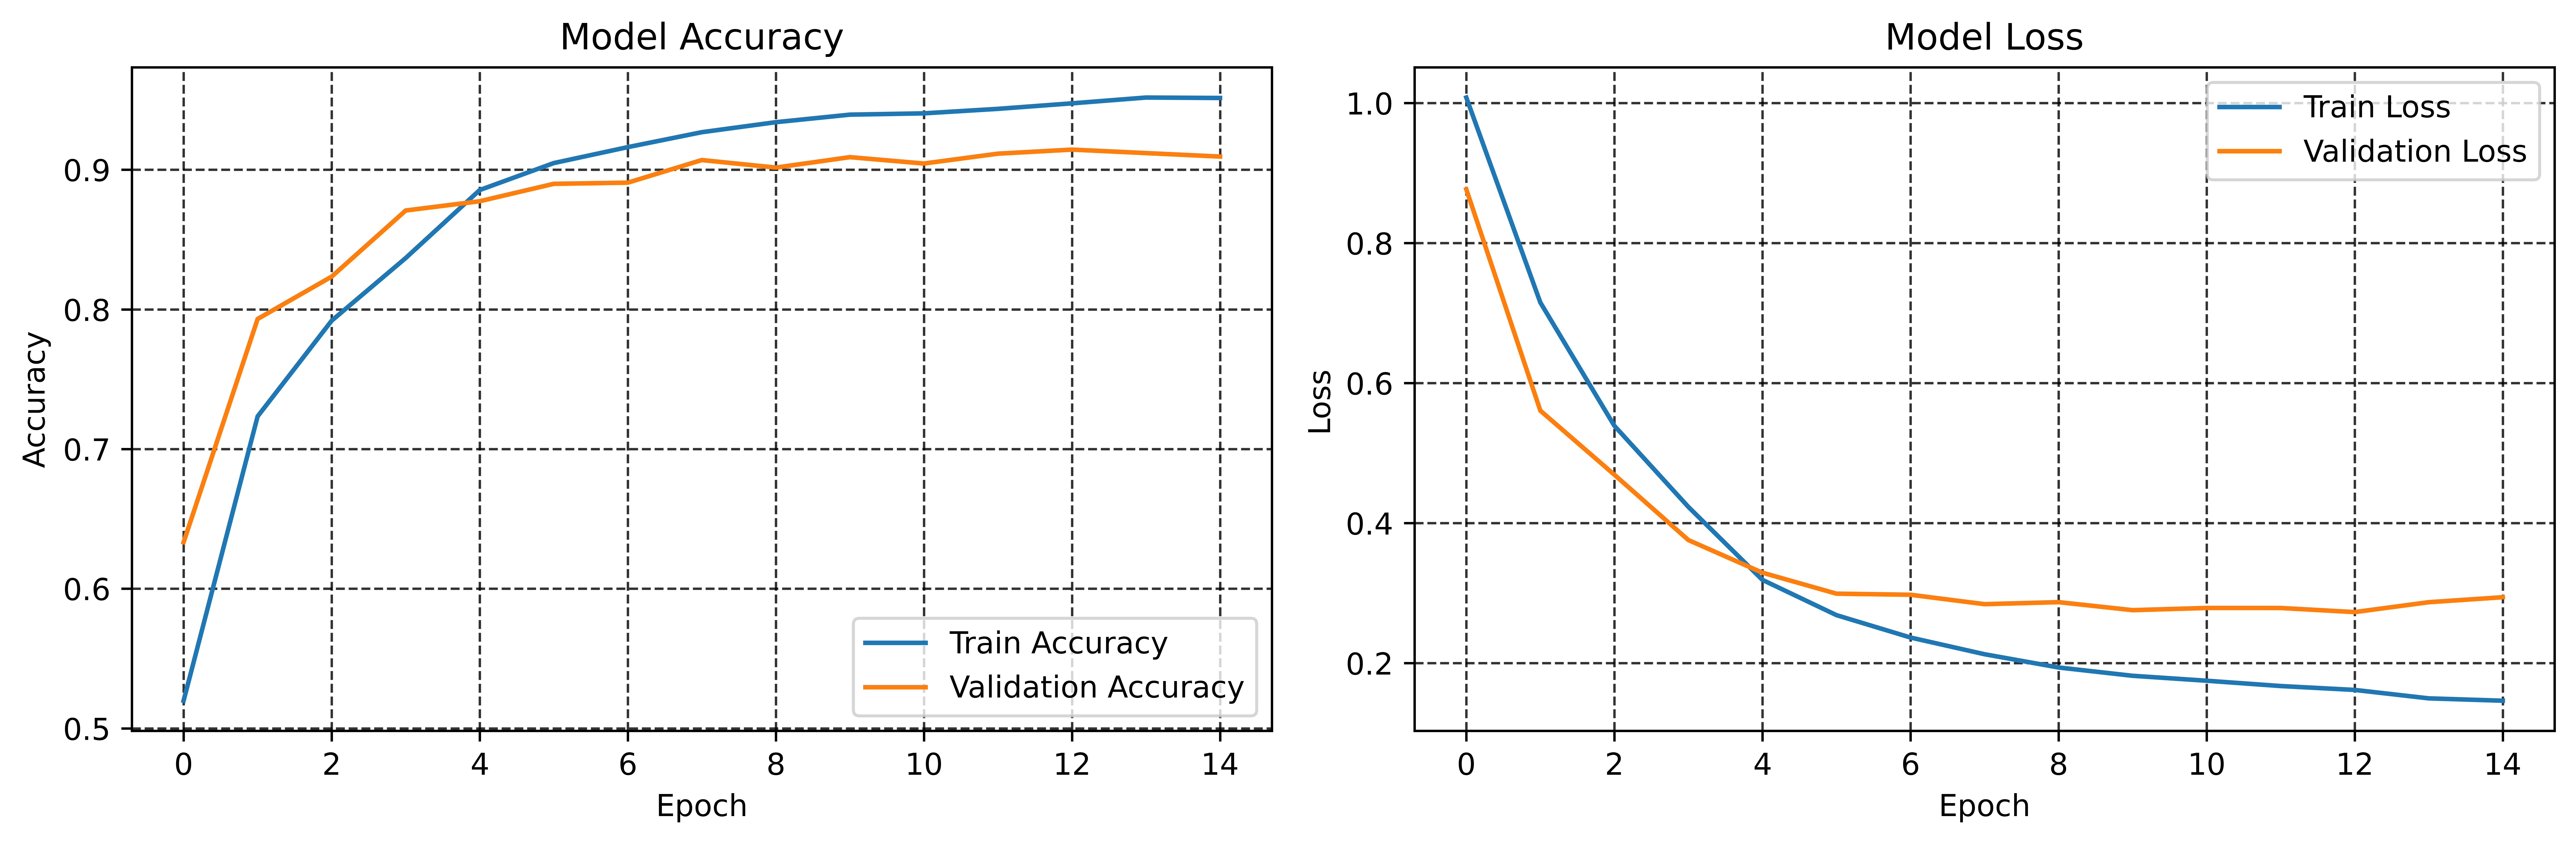

In [31]:
plt.figure(figsize=(12, 4),dpi=1000)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', color='black', alpha=0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', color='black', alpha=0.8)
plt.legend()

plt.tight_layout()
plt.show()

###Check O/P with sample text

In [32]:
# Function to predict the class of new text
def predict_class(text, model, tokenizer):
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([text])
    # Pad sequence
    padded = pad_sequences(sequence, maxlen=max_sequence_length)
    # Predict
    prediction = model.predict(padded)
    # Get class with highest probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    # Map class index to label
    class_names = {0: 'Science', 1: 'Math', 2: 'History'}
    return class_names[predicted_class], prediction[0][predicted_class]

In [33]:
# Test with some examples
example_texts = [
    "The gravitational force between two objects is directly proportional to the product of their masses.",
    "To solve this equation, we need to find the derivative of the function and set it equal to zero.",
    "The Roman Empire reached its greatest extent during the reign of Emperor Trajan."
]

for text in example_texts:
    predicted_class, confidence = predict_class(text, model, tokenizer)
    print(f"Text: {text}")
    print(f"Predicted class: {predicted_class} (Confidence: {confidence:.4f})")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Text: The gravitational force between two objects is directly proportional to the product of their masses.
Predicted class: Science (Confidence: 0.9877)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: To solve this equation, we need to find the derivative of the function and set it equal to zero.
Predicted class: Math (Confidence: 1.0000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: The Roman Empire reached its greatest extent during the reign of Emperor Trajan.
Predicted class: History (Confidence: 0.9997)



###Classification Report

In [34]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Generate classification report
class_names = ['Science', 'Math', 'History']
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)
print(report)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

     Science       0.84      0.90      0.87       989
        Math       0.94      0.93      0.94      1013
     History       0.92      0.86      0.89      1009

    accuracy                           0.90      3011
   macro avg       0.90      0.90      0.90      3011
weighted avg       0.90      0.90      0.90      3011

